# Extracting Characters from Cover Images

This notebook details how to take in a particular image and through a sequence of image processing steps, find the coordinates of bounding boxes for each character, crop the characters from the image using these coordinates and save the cropped images.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
%matplotlib inline

from sklearn.cluster import DBSCAN

## Resizing input image

The ***getImageResized( )*** function takes an image and scales it up or down depening how much of the image is empty.
The thinking behing this strategy is to be able to deal with very small fonts that occupy only a small percentage
of the cover image. Extracting characters from such pages without resizing results in groups of characters being 
recognized as one character beacause of their proximity to one another. Upscaling the image helps in getting more
distinct contours for the algorithm to identify.

In [2]:
"""
function that takes an image and resizes depending on 
the amount of empty space in the image. Also inverts the
proportion to extend the image horizontally.

Args:
    image_path: Input image path as a string

Returns:
    Resized image as a numpy array

Raises:
    AttributeError: Invalid image path raises exception
"""

def getImageResized(image_path):
    
    # reading the image in grayscale mode. Color images will be converted to grayscale
    img = cv2.imread(str(image_path),0)
    x,y = img.shape
    
    # Using the getContours1() function
    con = getContours1(img)
    area = 0
    
    # for each contour, calculate the area occupied and get the sum of all areas
    for c in con:
        area += cv2.contourArea(c)
    
    # If an image is of size 100 units, and detectable contours occupy only 10 units
    # it implies very small text size on a mostly plain background. We are blowing up
    # the image by 1/10th of the ratio of total space to occupied space.
    #
    # We are taking 1/10th because in case of large image sizes, it is very easy to
    # run into memory overflow issues.
    #
    # The change factor is the factor by which we blowing up the image.
    change_factor = int(np.ceil(img.size/area)//10)
    if change_factor == 0:
        change_factor = 1
    
    print('resizing image by factor of {}'.format(change_factor))
    
    # While resizing we also switch the proportions, which helps in extending
    # characters along the x-axis.
    img_reshape = cv2.resize(img,(x*change_factor,y*change_factor))
    
    return(img_reshape)

## Calculating proportion of relevant area

The **getContours1()** function is a helper function used by **getImageResized()**. This is a cursory contour extraction function to get an idea of how much empty space is present in the input image. The main difference between this and **getContours2()** is the kind of thresholding used. 

In this function, we use adaptive thresholding which as explained in the OpenCV documentation [here,](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html) calculates the threshold for small regions of the image. So we get different thresholds for different regions of the same image and it gives us better results for images with varying illumination.

The reason we using a separate function is because here accuracy is not important since we desire only a rough estimate. Hence we use a default block size (75) and C (10) for all images.

In [3]:
"""
function that takes an image and returns extracted contours after 
performing  adaptive thresholding on the image, using parameters 
block size = 75 and C = 10

Args:
    img: Input image as a numpy array with only 2 channels (grayscale)

Returns:
    A list of contours detected in the input image.

"""

def getContours1(img):
    # Gaussian blurring is highly effective in removing gaussian noise from the image.
    blur = cv2.GaussianBlur(img,(5,5),0)
    
    # performing adaptive thresholding
    th = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,75,10)
    
    # converting the image to white text on black background. This is 
    # necessary for OpenCV's findContours() function to work.
    img_bn = cv2.bitwise_not(th)
    
    # Extracting the contours from the image. A contour can be best explained as
    # a contiguous area of similar pixel values.
    con2, _ = cv2.findContours(img_bn, cv2.RETR_EXTERNAL, cv2.cv2.CHAIN_APPROX_SIMPLE)
    
    return con2

## Extracting contours from resized image

The **getContours2()** function is where the we take the resized image and perform the same preprocessing steps as in **getContours1()** and additionally perform dilation in order to enlarge indivdual characters.

Since we have continuous text characters which can be very close to each other, in some fonts we often get two characters merged in one single bounding box. To fix this, we perform dilation on the image where we define a kernel size and as the kernel is scanned over the image, we compute the maximal pixel value overlapped by the kernel and replace the image pixel with that maximal value. Im simpler terms, when performed on white pixels on black background, dilation enlarges the white pixels. More explanation about dilation can be found [here.](https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html)

But in this pipeline, we still have black text on white background. So this operation effectively enarges the spaces between each character making it easier to identify characters separately. Now, this is very similar to taking the inverse of this image and performing erosion to minimize the chracter size. But while executing the operation, we consistently observed much better results by following this particular order and hence stuck to it.

The **findContours()** function then extracts contours from the image and returns them as a list which is then used to calculate the coordinates for each characters' bounding box. While OpenCV documentation on this subject can be found [here,](https://docs.opencv.org/3.4.2/d4/d73/tutorial_py_contours_begin.html) [Software Carpentry's page on Image Processing](https://mmeysenburg.github.io/image-processing/09-contours/) was one of the resources we found most helpful in understanding this subject.

Another significant change is the use of [Otsu's Binarization Method](https://en.wikipedia.org/wiki/Otsu%27s_method) to perform thresholding instead of adaptive thresholding. This method automatically calculates a threshold value from image histogram for a bimodal image. More details about this method can be found [here.](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html)

The **getContours2()** function is where the we take the resized image and perform the same preprocessing steps as in **getContours1()** and additionally perform dilation in order to enlarge indivdual characters.

In [4]:
"""
function that takes an image and returns extracted contours after 
performing thresholding using Otsu's Binarization and dilation of
the result using a fixed kernel size

Args:
    img: Input image as a numpy array with only 2 channels (grayscale)

Returns:
    A list of contours detected in the input image.

"""

def getContours2(img):
    # Gaussian blurring is highly effective in removing gaussian noise from the image.
    blur = cv2.GaussianBlur(img,(5,5),0)
    
    # since we have a bimodal image (a black and white image), we prefer Otsu's Binarization
    # method as opposed to adaptive thresholding which was used earlier
    ret3,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # we define a kernel size to perform convolution with the image in order to dilate it 
    kernel = np.ones((3,3), np.uint8)
    
    # this process dilates the image thereby increasing the distance between individual characters
    # NOTE: SOMETIMES TOO MANY ITERATIONS RESULT IN LOSS OF INFORMATION. IN THAT CASE, DECREASING 
    # THE VALUE OF ITERATIONS IS THE BEST COURSE
    img_dilation = cv2.dilate(th, kernel, iterations=3)
    
    # converting the image to white text on black background. This is 
    # necessary for OpenCV's findContours() function to work.
    img_bn = cv2.bitwise_not(img_dilation)
    
    # Extracting the contours from the image. A contour can be best explained as
    # a contiguous area of similar pixel values.
    con2, _ = cv2.findContours(img_bn, cv2.RETR_EXTERNAL, cv2.cv2.CHAIN_APPROX_SIMPLE)
    
    return img_bn,con2

## Using the extracted contours to get bounding box coordinates for each character

Getting the corresponding bounding box coordinates for each contour is very straightforward using OpenCV's [boundingRect()](https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html) command. But the major challenges in making use of these coordinates was an inability to differentiate characters belonging to separate lines. Sorting by only x or y coordinates or a combination of the two resulted in order that wasnt accurate. The **getSortedCoordinates()** function using a clustering algorithm to fix this issue.

NOTE: An issue that is still not fixed were with respect to grouping of characters belonging to the same letter (the dots on i's are being classified as a separate character)


In [5]:
"""
helper function that takes a list of contours and for each contour
returns the coordinates using OpenCV's boundingRect() function. For 
a single contour c, cv2.boundingRect(c) returns 4 coordinates -- 
(x,y,w,h) that specify the bottom left (x,y) coordinates and the
image width(w) and height(h).

Args:
    contour_list: a list of contours generated by cv2.findContours()

Returns:
    4 lists of coordinates, one each for x, y, w and h.

"""

def getBoundingBoxesCoordinates(contour_list):
    coord = []
    
    # iterate through the contours
    for i in contour_list:
        # get the coordinates
        coord.append(cv2.boundingRect(i))
    
    # return x,y,w,h values as separate lists
    x = [i[0] for i in coord]
    y = [i[1] for i in coord]
    w = [i[2] for i in coord]
    h = [i[3] for i in coord]
    
    return(x,y,w,h)

In [6]:
"""
helper function that takes a list of contours and for each contour
returns the area bound by that particular contour. Can be used to
eliminate very small contours that are most likely noise.

Args:
    contour_list: a list of contours generated by cv2.findContours()

Returns:
    A list of values of contour areas.

"""

def getAreas(contour_list):
    areas_list = []
    
    #iterate through the contours
    for c in contour_list:
        # calculate contour area and append to list
        areas_list.append(cv2.contourArea(c))
        
    # return list as a numpy array
    return(np.asarray(areas_list).reshape(-1,1))

In [7]:
"""
function that takes a list of contours, and returns a list
of corrdinates in order of the text on the page. 

First, the (x,y,w,h) coordinates and area for contours are 
calculated using the helper functions. Sklearn's DBSCAN is 
used to cluster points based on y coordinate values. This
helps to differentiate between lines of text. 

Finally, it sorts the values in descending order of labels 
-- In OpenCV, y coordinates for an input image are ordered 
with the top of the image starting at 0 -- and in ascending
order of the x coordinates.

Args:
    contour_list: a list of contours generated by cv2.findContours()

Returns:
    A numpy array having sorted (x,y,w,h,area,label) values
    sorted by increasing x and decreasing label values.

"""

def getSortedCoordinates(contour_list):
    # gets lists of coordinates from contours list
    x,y,w,h = getBoundingBoxesCoordinates(contour_list)
    
    # gets list of areas from contours list
    areas = getAreas(contour_list)
    
    # converts lists to numpy arrays
    x = np.asarray(x).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
    w = np.asarray(w).reshape(-1,1)
    h = np.asarray(h).reshape(-1,1)
    
    # calculates mean height of contours
    mean_height = np.mean(h)
    
    # get labels for y coordinates using a DBSCAN model where maximum 
    # distance for characters in same row is half the mean height. This 
    # helps label only characters in same row together
    db = DBSCAN(eps=mean_height/2,min_samples=1).fit(y)
    y_labels = db.labels_.reshape(-1,1)
    
    # concatenate the x,y,w,h,areas and label values into a single array
    t1 = np.concatenate((x,y,w,h,areas,y_labels), axis=1)
    
    # create a structured array from the array above
    dtype = [('x_coord',int),('y_coord',int),('width',int),('height',int),('area',float),('label',int)]
    values = []
    for i in t1:
        values.append((i[0],i[1],i[2],i[3],i[4],i[5]))
    a = np.array(values, dtype=dtype)
    
    # sort by increasing x coordinate values and decreasing label values
    out = a[np.lexsort((a['x_coord'], -a['label']))]
    
    return(out)

## Performing character extraction on sample images

After explaining all the functions in the previous half of the notebook, now we will see them in action on 2 images. To show the robustness of the pipeline we have used 2 very different images. 

Image 'x.jpg' has a very small font size and italic font which results in the characters being extremely closed to each each other.

Meanwhile, image 'y.jpg' has a very large font size which results in big characters occupying most of the page.

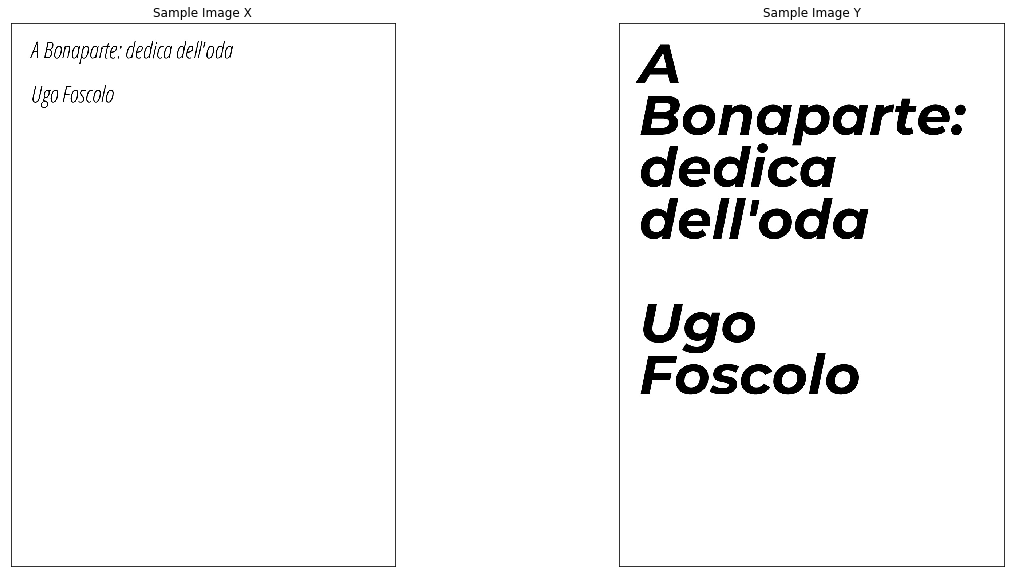

In [8]:
img_x_temp = cv2.imread('x.jpg')
img_y_temp = cv2.imread('y.jpg')

plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(img_x_temp)
plt.title('Sample Image X'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_y_temp)
plt.title('Sample Image Y'), plt.xticks([]), plt.yticks([])

plt.show()

### Character Extraction for Image X

#### Resizing the Image

In [9]:
img_x = getImageResized('x.jpg')

resizing image by factor of 10


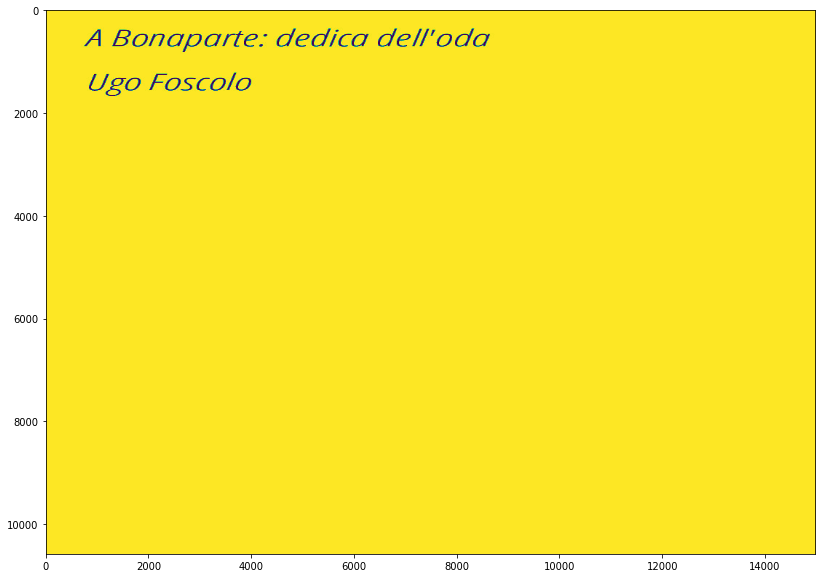

In [10]:
plt.figure(figsize=(20,10))
plt.imshow(img_x)
plt.show()

#### Getting the contours for Image X

In [11]:
output_image_x,contour_list_x = getContours2(img_x)

As we can see below, the contour list returned is a list

In [12]:
type(contour_list_x)

list

#### Using the extracted contours to get bounding box coordinates for Image X in sorted order

In [13]:
coord_img_x = getSortedCoordinates(contour_list_x)

A quick glance at the length of the coordinate list shows the proximity to the number of characters in the image.

In [14]:
len(coord_img_x)

37

#### Cropping the individual characters

The code to save the output character images has been commented out here. To save the images, simply uncomment the relevant code.

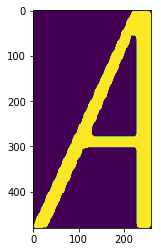

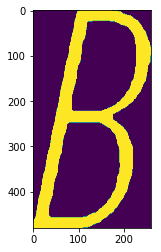

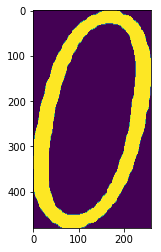

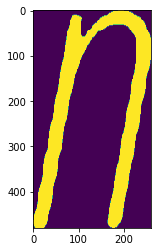

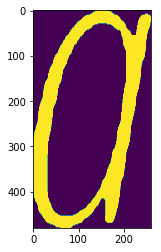

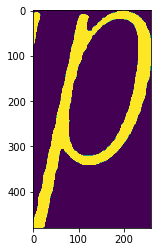

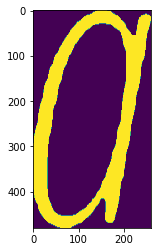

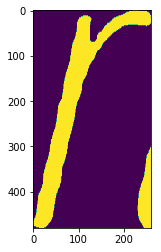

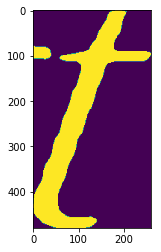

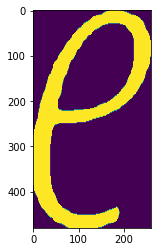

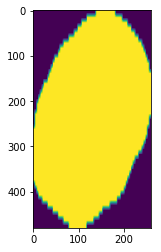

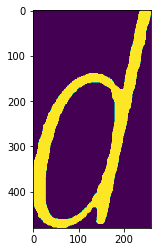

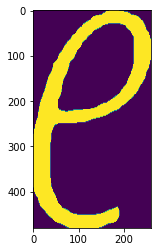

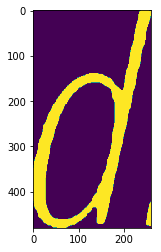

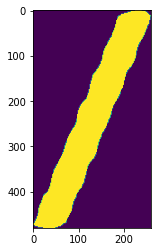

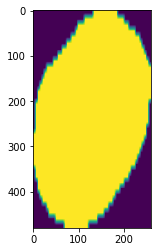

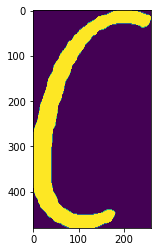

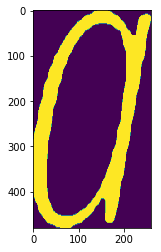

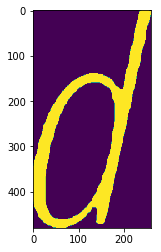

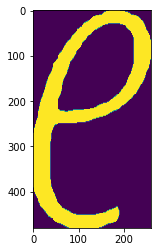

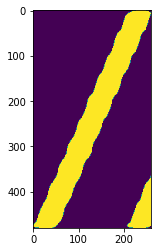

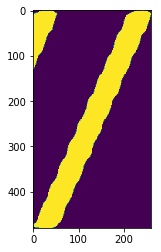

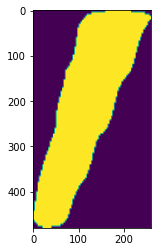

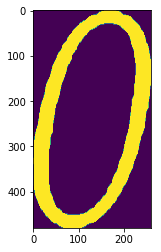

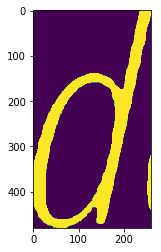

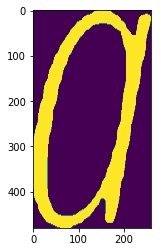

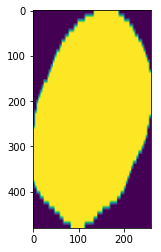

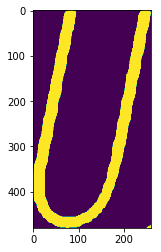

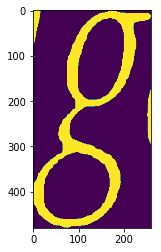

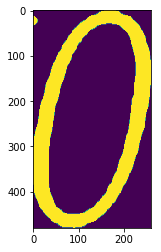

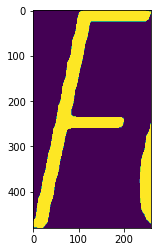

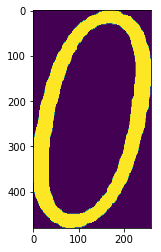

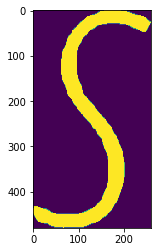

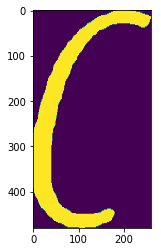

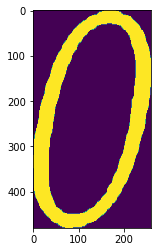

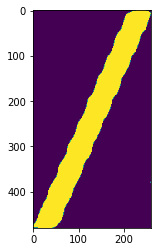

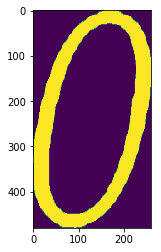

In [15]:
# k is a counter to append a number to images when saving
# k = 1

# iterate through the list of contours
for c in coord_img_x:
    # get the relevant values
    x1,y1,w1,h1,_,_ = c
    
    # use the values to crop the character area from the image
    # NOTE: We using the output image returned by getCOntours2()
    cropped_og = output_image_x[y1:y1+h1, x1:x1+w1]
    cropped_resized = cv2.resize(cropped_og,(260,480))
    
    # uncomment code below to save images
    # s = ("cropped_{}_.jpg".format(k))
    # cv2.imwrite(s , cropped)
    # k += 1
    
    plt.imshow(cropped_resized)
    plt.show()

### Character Extraction for Image Y

#### Resizing the Image

In [16]:
img_y = getImageResized('y.jpg')

resizing image by factor of 1


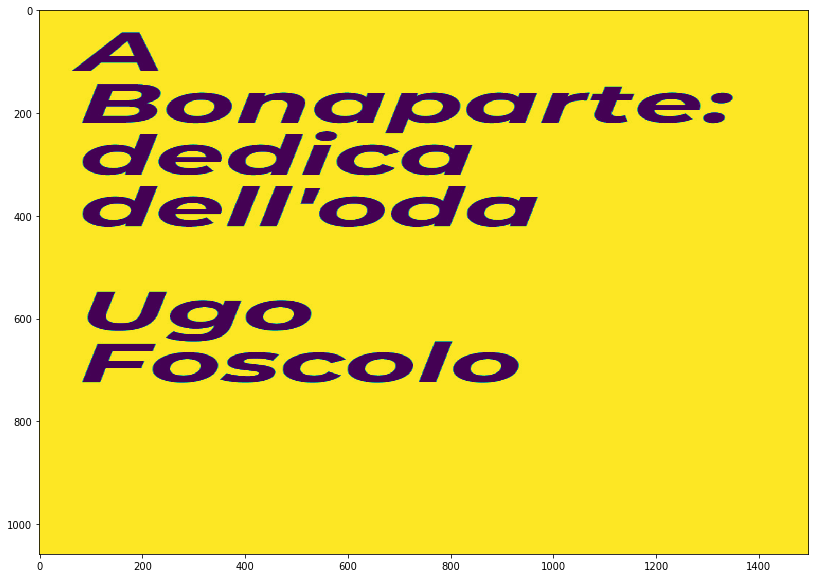

In [17]:
plt.figure(figsize=(20,10))
plt.imshow(img_y)
plt.show()

#### Getting the contours for Image Y

In [18]:
output_image_y,contour_list_y = getContours2(img_y)

As we can see below, the contour list returned is a list

In [19]:
type(contour_list_y)

list

#### Using the extracted contours to get bounding box coordinates for Image Y in sorted order

In [20]:
coord_img_y = getSortedCoordinates(contour_list_y)

A quick glance at the length of the coordinate list shows the proximity to the number of characters in the image.

In [21]:
len(coord_img_y)

37

#### Cropping the individual characters

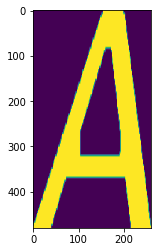

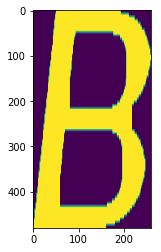

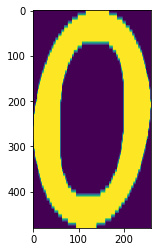

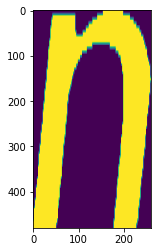

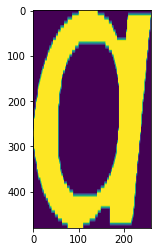

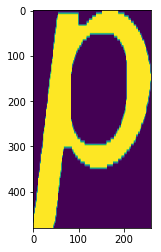

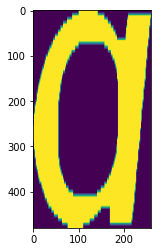

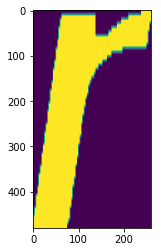

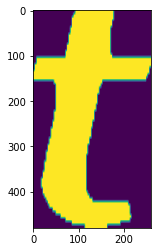

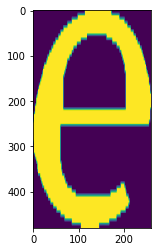

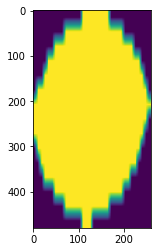

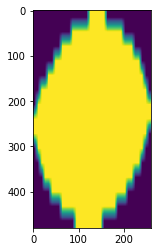

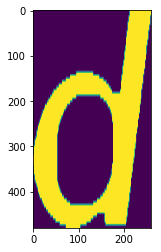

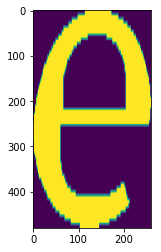

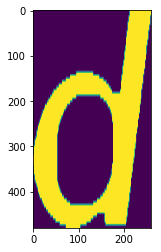

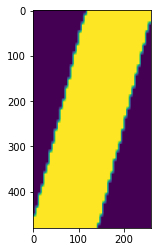

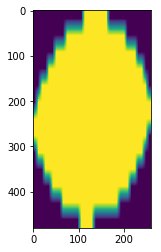

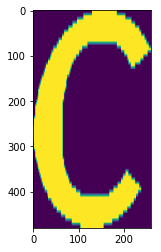

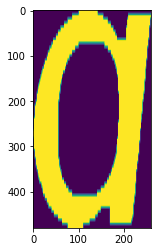

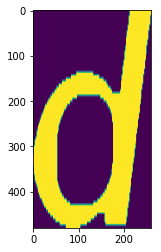

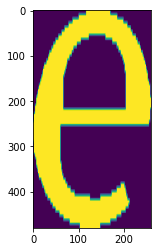

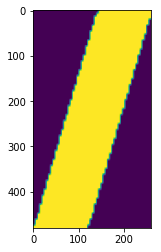

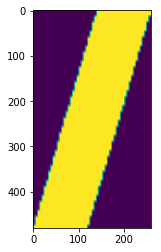

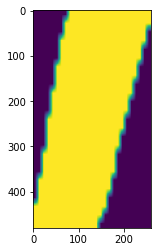

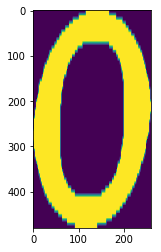

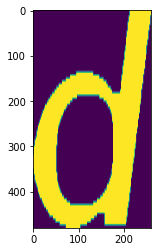

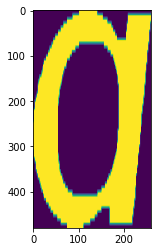

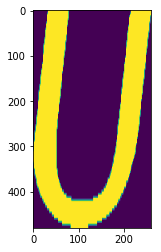

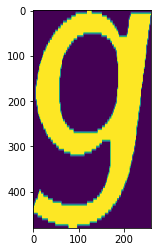

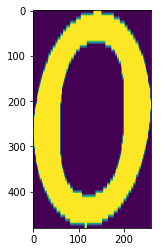

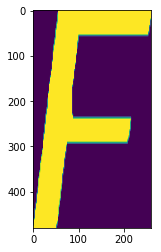

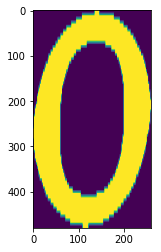

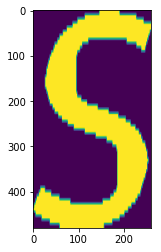

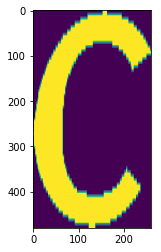

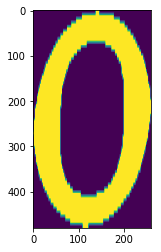

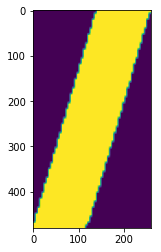

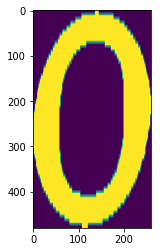

In [22]:
# k is a counter to append a number to images when saving
# k = 1

# iterate through the list of contours
for c in coord_img_y:
    # get the relevant values
    x1,y1,w1,h1,_,_ = c
    
    # use the values to crop the character area from the image
    # NOTE: We using the output image returned by getCOntours2()
    cropped_og = output_image_y[y1:y1+h1, x1:x1+w1]
    cropped_resized = cv2.resize(cropped_og,(260,480))
    
    # uncomment code below to save images
    # s = ("cropped_{}_.jpg".format(k))
    # cv2.imwrite(s , cropped)
    # k += 1
    
    plt.imshow(cropped_resized)
    plt.show()

## Problems and Future Work

1. Though we are able to generate clean characters for out test images, 